# Movies Portfolio Analysis

<h2>Table of Contents</h2>

<ul style="font-size: 16px; line-height: 1.8;">
  <li><a href="#1-introduction-and-goal"><b>1) Introduction and Goal</b></a></li>
  <li><a href="#2-data-understanding-and-preparation"><b>2) Data Understanding and Preparation</b></a></li>
  <li><a href="#3-descriptive-statistics"><b>3) Descriptive Statistics</b></a></li>
  <li><a href="#4-univariate-distributions"><b>4) Univariate Distributions</b></a></li>
  <li><a href="#bivariate-analysis"><b>5) Bivariate Relationships</b></a></li>
  <li><a href="#6-audience-focused-visualizations"><b>6) Audience-Focused Visualizations</b></a></li>
  <li><a href="#7-conclusions"><b>7) Conclusions</b></a></li>
</ul>

## 1) Intruduction and Goal: 

The goal of this project is to explore the relationships between audience reception, critic evaluations, box office revenue, and profitability for a set of popular movies released between 2007 and 2011.

Specifically, this analysis aims to:
- Examine the relationship between audience scores and critic scores.
- Assess whether higher audience or critic ratings are associated with higher worldwide gross.
- Investigate the relationship between revenue and profitability, recognizing that strong box office performance does not necessarily imply high profitability.
- Identify genre-level patterns using aggregated metrics (e.g. median values) to better understand differences in audience preferences and critical reception.
- Apply appropriate transformations (e.g. log-transformed revenue) to address skewed distributions and improve interpretability.

The project emphasizes exploratory data analysis and visual interpretation rather than predictive modeling, with the objective of deriving clear, data-driven insights from real-world movie performance data.

## 2) Data Understanding and Preparation

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns

#diagram genral settings
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["axes.titlecolor"] = "#222222"
plt.rcParams["axes.titlepad"] = 12
plt.rcParams["axes.titlelocation"] = "center"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "italic"

plt.rcParams["axes.facecolor"] = "#F3E6D3"

plt.rcParams.update({
    "axes.facecolor": "#F3E6D3",
    "axes.grid": True,
    "grid.alpha": 0.12,
    "axes.axisbelow": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
})

In [299]:
df = pd.read_csv('movies.csv')
print(df.shape)
print(df.info())
df.head()

(77, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film               77 non-null     object 
 1   Genre              77 non-null     object 
 2   Lead Studio        77 non-null     object 
 3   Audience score %   77 non-null     int64  
 4   Profitability      77 non-null     float64
 5   Rotten Tomatoes %  77 non-null     int64  
 6   Worldwide Gross    77 non-null     object 
 7   Year               77 non-null     int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 4.9+ KB
None


,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
0,Zack and Miri Make a Porno,Romance,The Weinstein Company,70,1.747542,64,$41.94,2008
1,Youth in Revolt,Comedy,The Weinstein Company,52,1.090000,68,$19.62,2010
2,You Will Meet a Tall Dark Stranger,Comedy,Independent,35,1.211818,43,$26.66,2010
3,When in Rome,Comedy,Disney,44,0.000000,15,$43.04,2010
4,What Happens in Vegas,Comedy,Fox,72,6.267647,28,$219.37,2008


In [300]:
df.duplicated().sum()

np.int64(2)

In [301]:
df["Genre"].value_counts()

Genre
Comedy       41
Romance      13
Drama        13
Animation     4
Fantasy       1
Romence       1
Comdy         1
Action        1
romance       1
comedy        1
Name: count, dtype: int64

In [302]:
df["Worldwide Gross"].head(10)

0     $41.94 
1     $19.62 
2     $26.66 
3     $43.04 
4    $219.37 
5    $117.09 
6    $521.28 
7     $22.18 
8      $0.03 
9    $217.57 
Name: Worldwide Gross, dtype: object

Initial observations:
- Dataset contains movie-level data with ratings, profitability, and revenue.
- Some columns need cleaning (genre names, duplicates, currency format).
- Profitability includes zero values that may represent missing data.

### Data Wrangling and Tidying

In this section, I clean the dataset by removing exact duplicates, standardizing genre labels, converting currency to numeric, and handling zero profitability values.

In [303]:
df_raw = df.copy()

print("Rows (before):", df.shape[0])
print("Exact duplicates (before):", df.duplicated().sum())
print("Genre unique values (before):", df["Genre"].nunique())
print("Worldwide Gross dtype (before):", df["Worldwide Gross"].dtype)

Rows (before): 77
Exact duplicates (before): 2
Genre unique values (before): 10
Worldwide Gross dtype (before): object


In [304]:
df = df.drop_duplicates()

print("Rows (after drop_duplicates):", df.shape[0])
print("Exact duplicates (after):", df.duplicated().sum())

Rows (after drop_duplicates): 75
Exact duplicates (after): 0


In [305]:
# Remove leading and trailing spaces from the 'Genre' column
df["Genre"] = df["Genre"].str.strip()

# Replace incorrect or inconsistent genre names with correct, standardized ones
df["Genre"] = df["Genre"].replace({
    "Romence": "Romance",   # fix typo
    "Comdy": "Comedy",      # fix typo
    "romance": "Romance",   # standardize capitalization
    "comedy": "Comedy"      # standardize capitalization
})

# Count how many times each genre appears after cleaning
print(df["Genre"].value_counts())

Genre
Comedy       42
Romance      15
Drama        13
Animation     3
Fantasy       1
Action        1
Name: count, dtype: int64


In [306]:
# Convert the 'Worldwide Gross' column to string
# This ensures string operations can be applied safely
df["Worldwide Gross"] = (
    df["Worldwide Gross"]
    .astype(str)
    .str.replace("$", "", regex=False)  # remove dollar sign
    .str.strip()                        # remove leading/trailing spaces
)

# Convert the cleaned column to numeric (float)
# Invalid values are converted to NaN instead of raising an error
df["Worldwide Gross"] = pd.to_numeric(
    df["Worldwide Gross"],
    errors="coerce"
)

# Check the data type after conversion
print("Worldwide Gross dtype (after):", df["Worldwide Gross"].dtype)

# Count missing values created during conversion
print("Worldwide Gross missing (after):", df["Worldwide Gross"].isna().sum())

# Preview the first 10 values
df["Worldwide Gross"].head(10)

Worldwide Gross dtype (after): float64
Worldwide Gross missing (after): 0


0     41.94
1     19.62
2     26.66
3     43.04
4    219.37
5    117.09
6    521.28
7     22.18
8      0.03
9    217.57
Name: Worldwide Gross, dtype: float64

In [307]:
# Interpreting 0 profitability as missing/unknown rather than true zero.
df["Profitability"] = df["Profitability"].replace(0, np.nan)

print("Profitability missing (after):", df["Profitability"].isna().sum())
df[["Film", "Profitability"]].head(10)

Profitability missing (after): 3


,Film,Profitability
0,Zack and Miri Make a Porno,1.747542
1,Youth in Revolt,1.090000
2,You Will Meet a Tall Dark Stranger,1.211818
3,When in Rome,NaN
4,What Happens in Vegas,6.267647
5,Water For Elephants,3.081421
6,WALL-E,2.896019
7,Waitress,11.089742
8,Waiting For Forever,0.005000
9,Valentine's Day,4.184038


In [308]:
df.info()
df.isna().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film               75 non-null     object 
 1   Genre              75 non-null     object 
 2   Lead Studio        75 non-null     object 
 3   Audience score %   75 non-null     int64  
 4   Profitability      72 non-null     float64
 5   Rotten Tomatoes %  75 non-null     int64  
 6   Worldwide Gross    75 non-null     float64
 7   Year               75 non-null     int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 5.3+ KB


,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
count,75.000000,72.000000,75.000000,75.000000,75.000000
mean,63.720000,4.715803,46.493333,138.377467,2009.066667
std,13.699043,8.236327,26.412207,156.985150,1.349007
min,35.000000,0.005000,3.000000,0.030000,2007.000000
25%,52.000000,1.794048,26.000000,32.495000,2008.000000
50%,64.000000,2.645711,43.000000,77.090000,2009.000000
75%,75.000000,4.724879,64.500000,199.635000,2010.000000
max,89.000000,66.934000,96.000000,709.820000,2011.000000


**After cleaning:**
- The dataset contains 75 movies.
- Two exact duplicate rows were removed.
- Worldwide Gross was successfully converted to a numeric (float) variable.

## 3) Descriptive Statistics

In this section, I summarize the main numerical variables to understand
their central tendency, spread, and overall scale before visual exploration.

In [309]:
numeric_cols = [
    "Audience score %",
    "Rotten Tomatoes %",
    "Worldwide Gross",
    "Profitability"
]

df[numeric_cols].describe()

,Audience score %,Rotten Tomatoes %,Worldwide Gross,Profitability
count,75.000000,75.000000,75.000000,72.000000
mean,63.720000,46.493333,138.377467,4.715803
std,13.699043,26.412207,156.985150,8.236327
min,35.000000,3.000000,0.030000,0.005000
25%,52.000000,26.000000,32.495000,1.794048
50%,64.000000,43.000000,77.090000,2.645711
75%,75.000000,64.500000,199.635000,4.724879
max,89.000000,96.000000,709.820000,66.934000


In [310]:
df[numeric_cols].median()

Audience score %     64.000000
Rotten Tomatoes %    43.000000
Worldwide Gross      77.090000
Profitability         2.645711
dtype: float64

**Key observations:**

- Audience scores are generally higher than critic scores.
  The median audience score is 64%, while the median Rotten Tomatoes score is 43%.

- Audience reception is relatively consistent (std ≈ 13.7),
  whereas critic scores show higher variability (std ≈ 26.4).

- Worldwide Gross has a strong right-skewed distribution.
  While the median gross is 77 million, the maximum exceeds 700 million,
  indicating a small number of extremely high-grossing movies.

- Profitability varies substantially across movies.
  The median profitability is approximately 2.65, but the maximum reaches
  nearly 67, suggesting the presence of extreme outliers.


## 4) Univariate Distributions

In this section, I visualize the distributions of the main numerical variables
to understand shape (skewness), spread, and potential outliers.

### Audience Score Distribution

**Question:** How are audience scores distributed across the movies in the dataset?

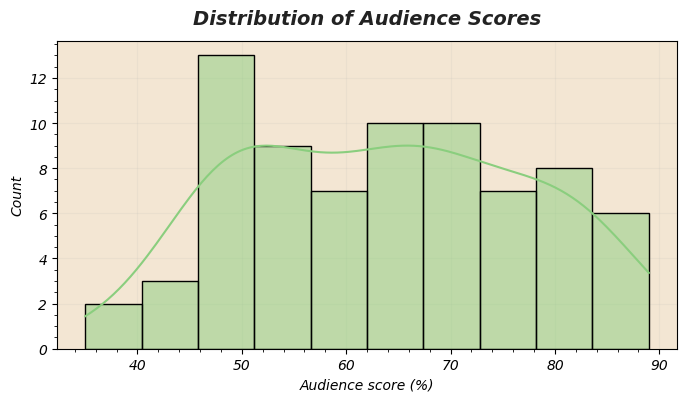

In [311]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Audience score %"], bins=10, kde=True, color="#8ACE7E")
plt.title("Distribution of Audience Scores")
plt.xlabel("Audience score (%)")
plt.ylabel("Count")
plt.show()

**Observation:**
- The distribution shows that most audience scores cluster in the medium-to-high range.
- Scores are relatively evenly spread, with few extremely low values.
- The distribution is approximately symmetric, with no pronounced skewness.

### Rotten Tomatoes Score Distribution

**Question:** How are critic scores (Rotten Tomatoes %) distributed across the dataset?

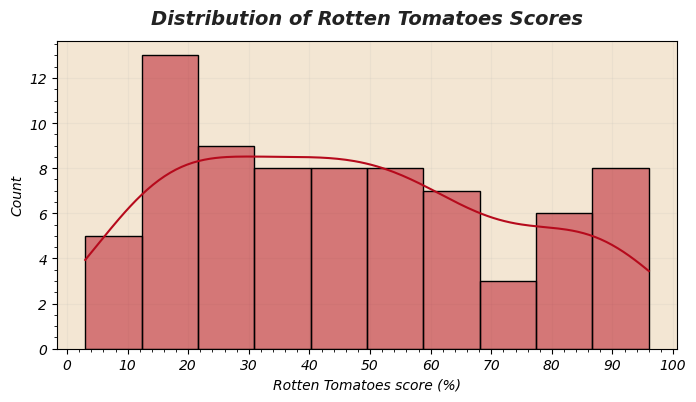

In [312]:
categories = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(8, 4))
sns.histplot(df["Rotten Tomatoes %"], bins=10, kde=True, color= "#B60A1C")
plt.xticks(categories)
plt.title("Distribution of Rotten Tomatoes Scores")
plt.xlabel("Rotten Tomatoes score (%)")
plt.ylabel("Count")
plt.show()

**Observation:**
- The distribution is wider and more dispersed compared to audience scores.
- A more substantial number of low values appears, while a few very high scores are also visible.
- This pattern indicates greater disagreement among critics.

### Worldwide Gross Distribution

**Question:** Is worldwide gross strongly right-skewed (a few very large box office hits)?
To make the distribution easier to read, I also use a log-transformed view.

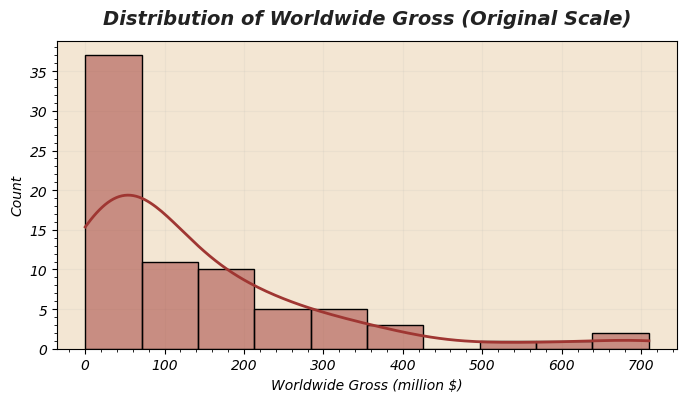

In [313]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Worldwide Gross"], bins=10, kde=True, color = "#9F3632", line_kws={"linewidth": 2})
plt.title("Distribution of Worldwide Gross (Original Scale)")
plt.xlabel("Worldwide Gross (million $)")
plt.ylabel("Count")
plt.show()

**Observation:**
- The distribution is strongly right-skewed, with most movies concentrated in the lower revenue range.
- A small number of extremely high-grossing films create a long right tail.
- The differences in revenue are visually very large, causing substantial distortion on the original scale.

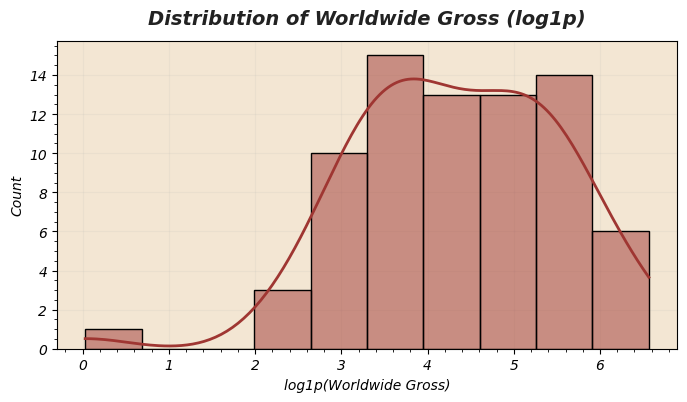

In [314]:
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df["Worldwide Gross"]), bins=10, kde=True, color= "#9F3632", line_kws={"linewidth": 2})
plt.title("Distribution of Worldwide Gross (log1p)")
plt.xlabel("log1p(Worldwide Gross)")
plt.ylabel("Count")
plt.show()

**Observation:**
- The log1p transformation visibly compresses very large grosses, so the distribution is easier to read than on the original scale.
- Most values fall roughly between ~3 and ~6 on the log1p scale, but the shape still does not look perfectly symmetric; it continues to taper off to the right.

- There is a small isolated group near zero, suggesting an outlier or a movie with extremely low gross.


<a id="bivariate-analysis"></a>
## 5) Bivariate Relationships (Two-Variable Analysis)

In this section, I explore how key variables relate to each other using scatter plots.  
Because **Worldwide Gross** is strongly right-skewed, I also use a **log1p** transformation where appropriate to make patterns easier to interpret.

### 5.1 Audience Score vs Rotten Tomatoes

**Question:** Do audience scores tend to align with critic scores in this dataset?

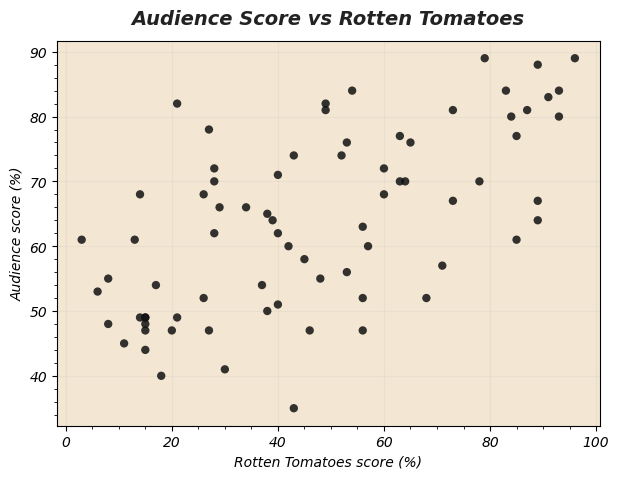

,Rotten Tomatoes %,Audience score %
Rotten Tomatoes %,1.000000,0.616563
Audience score %,0.616563,1.000000


In [325]:
x_col = "Rotten Tomatoes %"
y_col = "Audience score %"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5),)
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Audience Score vs Rotten Tomatoes")
plt.xlabel("Rotten Tomatoes score (%)")
plt.ylabel("Audience score (%)")

plt.show()

#correlation (quick numeric summary)
tmp[[x_col, y_col]].corr()

**Observation:**
- The scatter plot shows a moderate positive relationship between Rotten Tomatoes scores and audience scores.

- As critic scores increase, audience scores also tend to increase, but with noticeable dispersion, indicating that the relationship is not perfect.

- Several points deviate from the general trend, suggesting that some movies are received differently by critics and audiences despite similar scores.

- The correlation coefficient (≈ 0.62) supports the visual impression of a moderate, not strong, linear association.

### 5.2 Worldwide Gross vs Audience Score
**Question:** Do higher audience scores associate with higher worldwide gross?

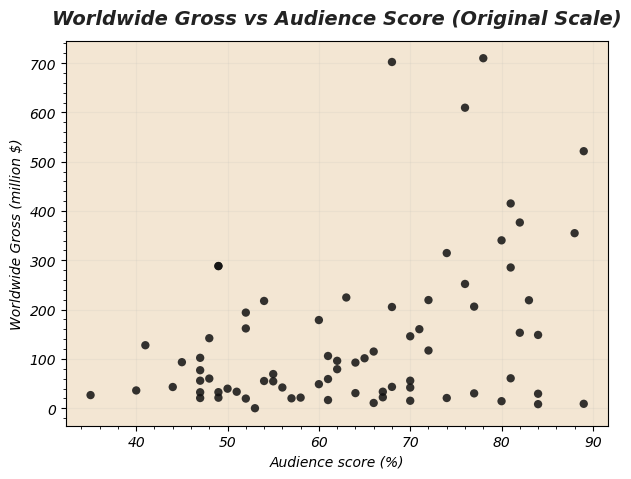

In [316]:
x_col = "Audience score %"
y_col = "Worldwide Gross"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Worldwide Gross vs Audience Score (Original Scale)")
plt.xlabel("Audience score (%)")
plt.ylabel("Worldwide Gross (million $)")
plt.show()

**Observation (original scale):**
- On the original scale, the relationship between audience score and worldwide gross is not clearly linear.

- Most movies cluster at lower gross values across a wide range of audience scores, which suggests that higher audience ratings do not automatically translate into high revenue.

- A small number of very high-grossing outliers dominate the vertical scale, making it harder to see subtler patterns among the majority of films.

- Overall, the plot hints that factors beyond audience score (e.g., distribution, marketing, franchise effects) likely play a major role, so audience score alone appears to be a limited predictor on this scale.

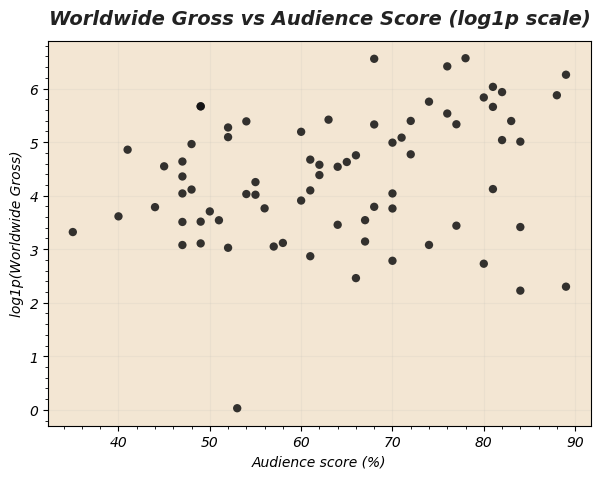

,Audience score %,log1p_gross
Audience score %,1.000000,0.260821
log1p_gross,0.260821,1.000000


In [317]:
# --- 5.2 Gross vs Audience (log1p scale) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[y_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp["log1p_gross"], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Worldwide Gross vs Audience Score (log1p scale)")
plt.xlabel("Audience score (%)")
plt.ylabel("log1p(Worldwide Gross)")
plt.show()

# correlation with log scale
tmp[[x_col, "log1p_gross"]].corr()

**Observation (log1p scale):**
- The log1p transformation reduces the influence of extreme revenue values, making the overall distribution easier to interpret.

- The plot suggests at most a weak positive association between audience score and worldwide gross.

- Considerable dispersion remains even in the mid-range of audience scores, indicating that additional factors likely play a major role in revenue outcomes.

- On the log-transformed scale, the structure of the data becomes clearer, but no strong linear relationship is evident.

### 5.3 Worldwide Gross vs Rotten Tomatoes

**Question:** Do higher critic scores associate with higher worldwide gross?

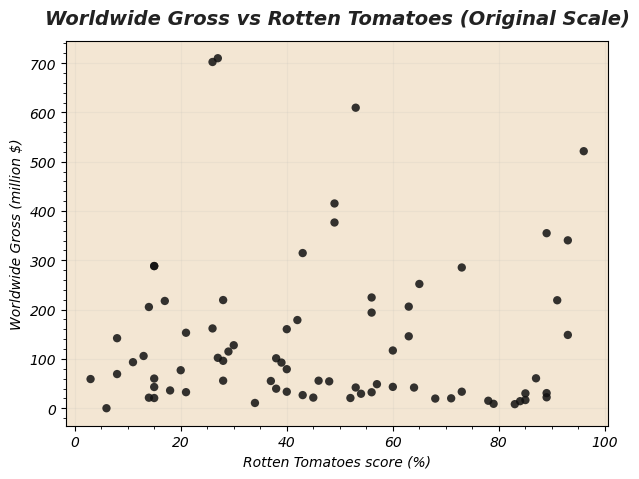

In [318]:
# --- 5.3 Gross vs Rotten Tomatoes (original scale) ---

x_col = "Rotten Tomatoes %"
y_col = "Worldwide Gross"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Worldwide Gross vs Rotten Tomatoes (Original Scale)")
plt.xlabel("Rotten Tomatoes score (%)")
plt.ylabel("Worldwide Gross (million $)")

plt.show()


**Observation (original scale):**
- The plot does not reveal a clear or strong relationship between Rotten Tomatoes scores and worldwide gross.

- Both high and low revenue outcomes appear across nearly the full range of critic scores.

- A few extremely high-grossing movies occur even at moderate or lower Rotten Tomatoes ratings, visually distorting the pattern.

- This suggests that critic scores alone are unlikely to be a dominant driver of worldwide box office performance.

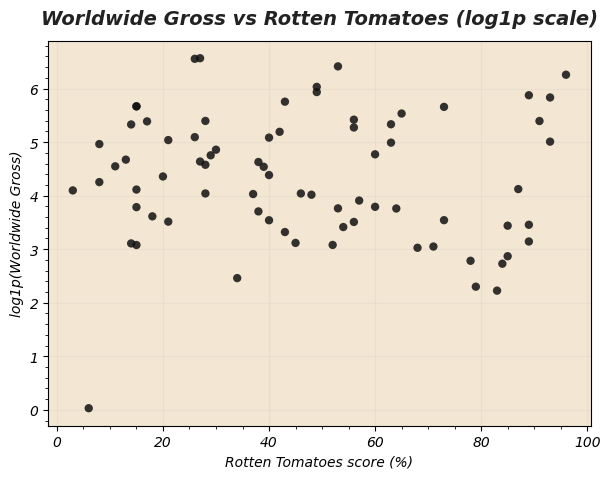

,Rotten Tomatoes %,log1p_gross
Rotten Tomatoes %,1.000000,-0.053129
log1p_gross,-0.053129,1.000000


In [319]:
# --- 5.3 Gross vs Rotten Tomatoes (log1p scale) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[y_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp["log1p_gross"], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Worldwide Gross vs Rotten Tomatoes (log1p scale)")
plt.xlabel("Rotten Tomatoes score (%)")
plt.ylabel("log1p(Worldwide Gross)")

plt.show()

# correlation with log scale
tmp[[x_col, "log1p_gross"]].corr()


**Observation (log1p scale):**
- The log1p transformation reduces the visual dominance of extreme revenue values, making the overall distribution easier to interpret.

- Even on the transformed scale, no clear relationship emerges between Rotten Tomatoes scores and worldwide gross.

- The points remain widely scattered, with similar revenue levels appearing across a broad range of critic ratings.

- The near-zero correlation suggests that critic scores have little to no consistent association with global box office performance.

### 5.4 Profitability vs Worldwide Gross

**Question:** Are higher-grossing movies also more profitable in this dataset?

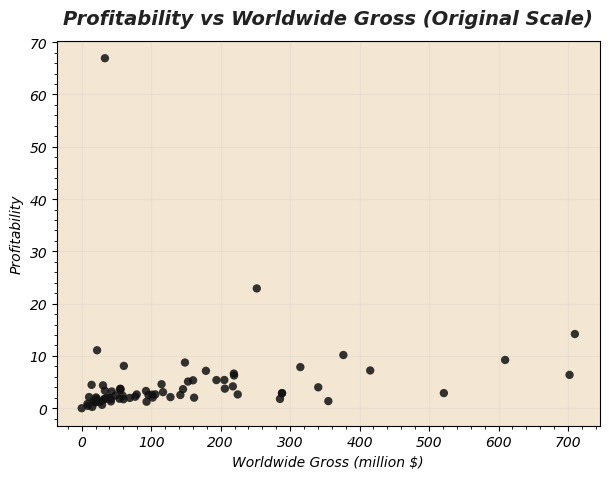

In [320]:
# --- 5.4 Profitability vs Gross (original scale) ---

x_col = "Worldwide Gross"
y_col = "Profitability"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Profitability vs Worldwide Gross (Original Scale)")
plt.xlabel("Worldwide Gross (million $)")
plt.ylabel("Profitability")

plt.show()

**Observation (original scale):**
- The plot does not show a clear linear relationship between worldwide gross and profitability.

- Higher worldwide gross does not consistently correspond to higher profitability values.

-  Some lower-grossing films exhibit relatively high profitability compared to certain high-grossing titles.

- This suggests that revenue alone is not sufficient to explain profitability differences across films.

These observations are based on visual patterns and should be interpreted cautiously, as profitability depends on cost structures not directly observed in this dataset.

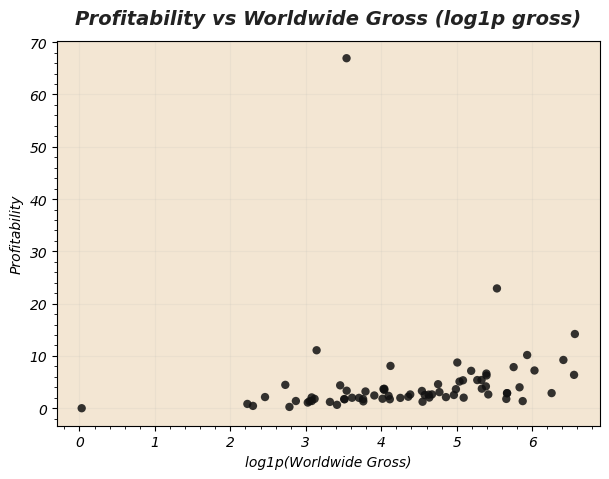

,log1p_gross,Profitability
log1p_gross,1.000000,0.133475
Profitability,0.133475,1.000000


In [321]:
# --- 5.4 Profitability vs Gross (log1p gross) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[x_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp["log1p_gross"], tmp[y_col], color= "#111111", alpha= 0.85, edgecolors= "none")
plt.title("Profitability vs Worldwide Gross (log1p gross)")
plt.xlabel("log1p(Worldwide Gross)")
plt.ylabel("Profitability")
plt.show()


# correlation with log scale
tmp[["log1p_gross", y_col]].corr()


**Observation (log1p scale):**
- The plot does not show a strong relationship between worldwide gross and profitability.

- Applying the log1p transformation reduces the impact of extreme revenue values, yet the data points remain widely dispersed.

- Higher-grossing movies do not consistently exhibit higher profitability.

- This suggests that revenue alone is not a key driver of profitability, and additional factors (such as production or marketing costs) may influence outcomes.

- The weak correlation supports interpreting this relationship as weak rather than predictive.

## 6) Audience-Focused Visualizations

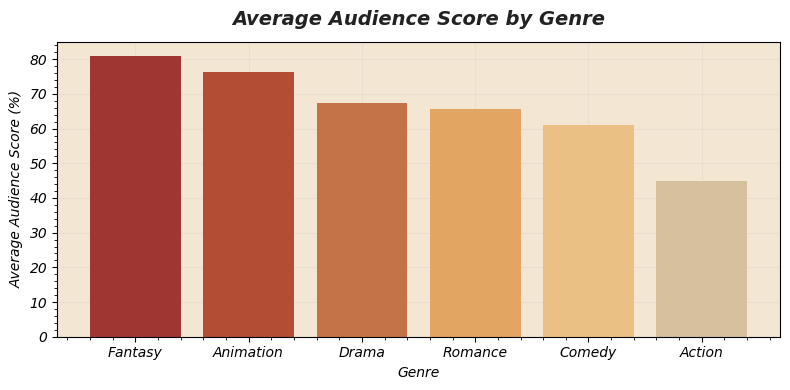

In [322]:
genre_avg = (
    df.groupby("Genre")["Audience score %"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
colors = ["#9F3632", "#B34D34", "#C47247", "#E2A562", "#EAC085", "#D6C19F"]
plt.bar(genre_avg.index, genre_avg.values, color = colors)
plt.title("Average Audience Score by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Audience Score (%)")
plt.tight_layout()
plt.show()

**Explanation:**  
This chart shows how audiences rated movies on average across different genres.  
Each bar represents a genre, and the height of the bar indicates the average audience score (%) for movies within that genre.  
The genres are sorted in descending order, making it easy to compare which types of movies were most favored by audiences.  
The goal of this visualization is to provide a quick and intuitive overview of audience preferences.


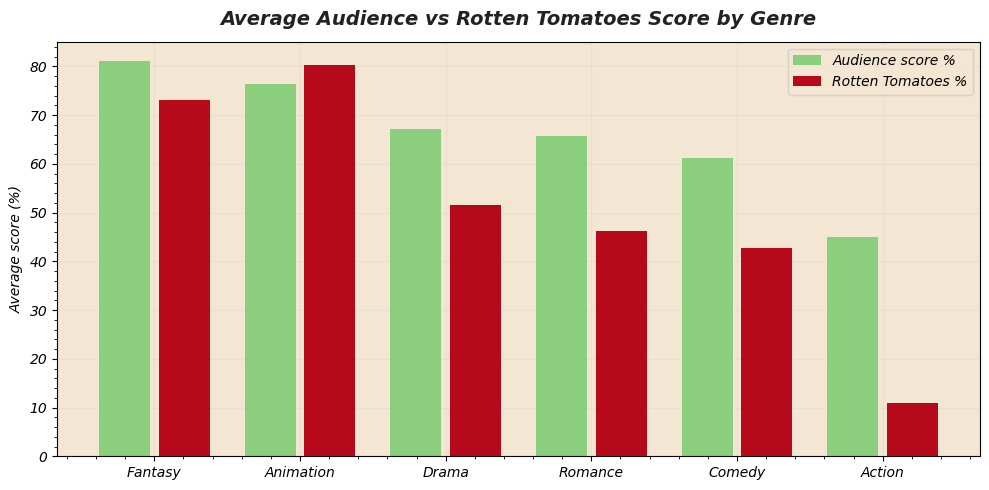

In [323]:
genre_means = (
    df.groupby("Genre")[["Audience score %", "Rotten Tomatoes %"]]
    .mean()
    .dropna()
    .sort_values("Audience score %", ascending=False)
)

x = np.arange(len(genre_means.index))
w = 0.35      # bar width
gap = 0.06    # Gap between the two bars within each genre

plt.figure(figsize=(10, 5))
plt.bar(x - (w/2 + gap/2), genre_means["Audience score %"], width=w, label="Audience score %", color="#8ACE7E")
plt.bar(x + (w/2 + gap/2), genre_means["Rotten Tomatoes %"], width=w, label="Rotten Tomatoes %", color="#B60A1C")

plt.title("Average Audience vs Rotten Tomatoes Score by Genre", color="#222222", fontsize=14, fontweight="semibold", pad=12, loc="center",  fontstyle="italic", family="sans-serif")
plt.xticks(x, genre_means.index)
plt.ylabel("Average score (%)")
plt.legend()
plt.tight_layout()
plt.show()


**Explanation:**  
This chart compares average audience scores and Rotten Tomatoes critic scores across movie genres.  
For each genre, two bars are shown side by side: one represents the average audience rating, while the other shows the average Rotten Tomatoes score.  
The genres are ordered by audience score in descending order, making it easy to see where audience opinions and critic reviews align or differ.  
The purpose of this visualization is to highlight differences between audience preferences and critic evaluations in a clear and intuitive way.


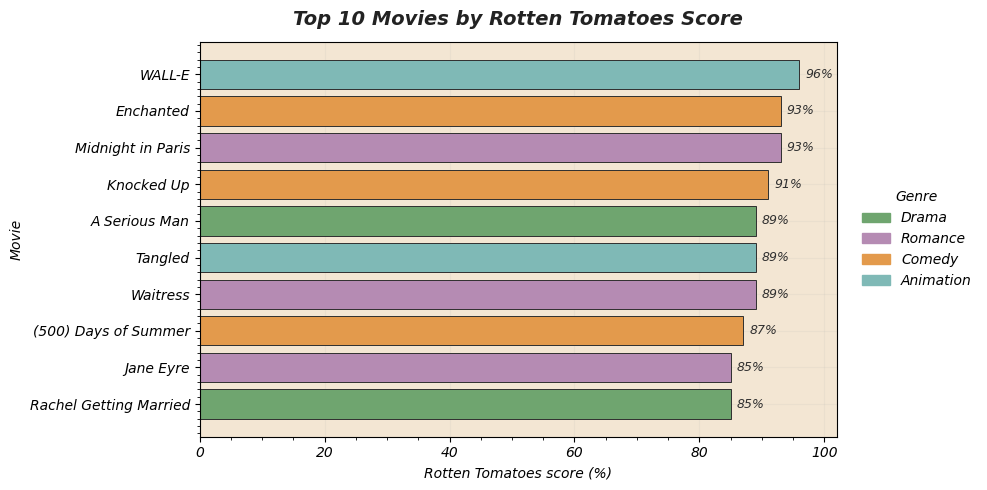

In [326]:

genre_colors = {
    "Action":    "#5B7DB1",
    "Comedy":    "#E39A4C",
    "Drama":     "#6FA56F",
    "Romance":   "#B58BB3",
    "Animation": "#7FB9B6",
    "Fantasy":   "#A07C6A"
}

# Select top 10 highest-rated movies by Rotten Tomatoes score
top10_rt = (
    df[["Film", "Genre", "Rotten Tomatoes %"]]
    .dropna()
    .nlargest(10, "Rotten Tomatoes %")
    .sort_values("Rotten Tomatoes %")
)

colors = top10_rt["Genre"].map(genre_colors)

plt.figure(figsize=(10, 5))
plt.barh(
    top10_rt["Film"],
    top10_rt["Rotten Tomatoes %"],
    color=colors,
    edgecolor="#2F2F2F",
    linewidth=0.7
)

# writing out values
for i, v in enumerate(top10_rt["Rotten Tomatoes %"]):
    plt.text(v + 1, i, f"{v:.0f}%", va="center", fontsize=9, color="#2F2F2F")
plt.xlim(0, 102)
plt.title("Top 10 Movies by Rotten Tomatoes Score", color="#222222", fontsize=14, fontweight="semibold", pad=12, loc="center",  fontstyle="italic", family="sans-serif")
plt.xlabel("Rotten Tomatoes score (%)")
plt.ylabel("Movie")

# Bar colors represent movie genres
genres_in_plot = top10_rt["Genre"].dropna().unique()
handles = [mpatches.Patch(color=genre_colors[g], label=g) for g in genres_in_plot]

plt.legend(
    handles=handles,
    title="Genre",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

**Explanation:**  
This chart presents the top 10 movies based on their Rotten Tomatoes critic scores.  
Each bar represents a movie, with the bar length indicating its Rotten Tomatoes score (%).  
The bars are color-coded by genre, allowing viewers to quickly see how different genres are represented among the highest-rated movies.  
The purpose of this visualization is to highlight top-performing films while also showing genre distribution in an intuitive and easy-to-read way.

## 7) Conclusions

This analysis shows that audience scores and critic scores are moderately correlated, indicating partial alignment between general audience reception and professional reviews, while still allowing for notable disagreements on specific films.

Neither audience scores nor critic scores exhibit a strong or consistent relationship with worldwide box office revenue. Several highly rated movies achieve only moderate commercial success, while many high-grossing films receive average or even low ratings. This suggests that box office performance is influenced by additional factors such as marketing intensity, franchise recognition, release timing, and distribution scale.

Profitability demonstrates only a weak association with worldwide gross, even after applying log-transformed revenue. A number of lower-grossing films achieve relatively high profitability, whereas some high-revenue movies deliver modest returns. This highlights the importance of production budgets and cost efficiency, which are not directly observable in the available data.

Genre-level analysis reveals systematic differences between audience and critic evaluations. Across nearly all genres, average audience scores are higher than Rotten Tomatoes critic scores, indicating that audiences generally rate films more favorably than critics. The magnitude of this gap varies by genre, reflecting differences in audience expectations and critical standards. Animation stands out as a notable exception, where critic scores slightly exceed audience scores, suggesting stronger critical consensus relative to audience reception in this genre.

Overall, the findings demonstrate that ratings alone are limited predictors of commercial or financial success. Movie performance emerges as a multifaceted outcome shaped by audience appeal, critical reception, genre characteristics, and external business factors beyond numerical ratings.
